<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#前向算法" data-toc-modified-id="前向算法-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>前向算法</a></span></li><li><span><a href="#损失函数计算" data-toc-modified-id="损失函数计算-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>损失函数计算</a></span></li><li><span><a href="#反向传播部分" data-toc-modified-id="反向传播部分-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>反向传播部分</a></span></li></ul></div>

在正式开始之前，我们先来了解一下我们要做什么。在本次教程中，我们要构建两个神经网络，一个是构建两层的神经网络，一个是构建多层的神经网络，多层神经网络的层数可以自己定义。本次的教程的难度有所提升，但是我会力求深入简出。在这里，我们简单的讲一下难点，本文会提到**[LINEAR-> ACTIVATION]转发函数，比如我有一个多层的神经网络，结构是输入层->隐藏层->隐藏层->···->隐藏层->输出层**，在每一层中，我会首先计算Z = np.dot(W,A) + b，这叫做【linear_forward】，然后再计算A = relu(Z) 或者 A = sigmoid(Z)，这叫做【linear_activation_forward】，合并起来就是这一层的计算方法，所以每一层的计算都有两个步骤，先是计算Z，再计算A，你也可以参照下图：

我们来说一下步骤：

- 初始化网络参数
- 前向传播
    - 计算一层的中线性求和的部分
    - 计算激活函数的部分（ReLU使用L-1次，Sigmod使用1次）
    - 结合线性求和与激活函数
- 计算误差
- 反向传播
    - 线性部分的反向传播公式
    - 激活函数部分的反向传播公式
    - 结合线性部分与激活函数的反向传播公式
- 更新参数

In [21]:
import numpy as np 
import h5py 
import matplotlib.pyplot as plt 
import testCases
from dnn_utils import sigmoid, sigmoid_backward, relu, relu_backward
import lr_utils

%matplotlib inline
np.random.seed(1) 

In [22]:
def initialize_parameters(n_x, n_h, n_y):
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01 
    b2 = np.zeros((n_y, 1))
    
    parameters = {
        'W1':W1, 
        'b1':b1, 
        'W2':W2, 
        'b2':b2 }
    return parameters

In [23]:
def initialize_parameters_deep(layers_dims):
    '''
    parameters：
        layers_dims - 包含我们网络中每个图层的节点数量的列表
    '''
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims)
    
    for l in range(1, L):
        parameters["W"+str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) / np.sqrt(layers_dims[l - 1])
        parameters["b"+str(l)] = np.zeros((layers_dims[l], 1))
        
        assert(parameters["W"+str(l)].shape == (layers_dims[l], layers_dims[l-1]))
        assert(parameters["b"+str(l)].shape == (layers_dims[l], 1))
    
    return parameters

## 前向算法

In [24]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b 
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [25]:
def linear_activation_forward(A_prev, W, b, activation):
    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        A, activation_cache = relu(Z)
    
    assert(A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    
    return A, cache

#测试linear_activation_forward
A_prev, W,b = testCases.linear_activation_forward_test_case()

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "sigmoid")
print("sigmoid，A = " + str(A))

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "relu")
print("ReLU，A = " + str(A))


In [26]:
def L_model_forward(X,parameters):
    """
    实现[LINEAR-> RELU] *（L-1） - > LINEAR-> SIGMOID计算前向传播，也就是多层网络的前向传播，为后面每一层都执行LINEAR和ACTIVATION
    
    参数：
        X - 数据，numpy数组，维度为（输入节点数量，示例数）
        parameters - initialize_parameters_deep（）的输出
    
    返回：
        AL - 最后的激活值
        caches - 包含以下内容的缓存列表：
                 linear_relu_forward（）的每个cache（有L-1个，索引为从0到L-2）
                 linear_sigmoid_forward（）的cache（只有一个，索引为L-1）
    """
    caches = []
    A = X
    L = len(parameters) // 2
    for l in range(1,L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
    
    return AL,caches


## 损失函数计算

In [27]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = -np.sum( np.multiply(Y, np.log(AL)) + np.multiply((1-Y), np.log((1-AL))) ) / m 
    cost = np.squeeze(cost)
    
    return cost

## 反向传播部分

In [28]:
def linear_backward(dZ, cache):
    A_prev,  W, b = cache
    m = A_prev.shape[1]
    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

In [29]:
#测试linear_backward
dZ, linear_cache = testCases.linear_backward_test_case()

dA_prev, dW, db = linear_backward(dZ, linear_cache)
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

dA_prev = [[ 0.51822968 -0.19517421]
 [-0.40506361  0.15255393]
 [ 2.37496825 -0.89445391]]
dW = [[-0.10076895  1.40685096  1.64992505]]
db = [[0.50629448]]


In [30]:
def linear_activation_backward(dA, cache, activation='relu'):
    linear_cache, activation_cache = cache
    if activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [31]:
def L_model_backward(AL,Y,caches):
    """
    对[LINEAR-> RELU] *（L-1） - > LINEAR - > SIGMOID组执行反向传播，就是多层网络的向后传播
    
    参数：
     AL - 概率向量，正向传播的输出（L_model_forward（））
     Y - 标签向量（例如：如果不是猫，则为0，如果是猫则为1），维度为（1，数量）
     caches - 包含以下内容的cache列表：
                 linear_activation_forward（"relu"）的cache，不包含输出层
                 linear_activation_forward（"sigmoid"）的cache
    
    返回：
     grads - 具有梯度值的字典
              grads [“dA”+ str（l）] = ...
              grads [“dW”+ str（l）] = ...
              grads [“db”+ str（l）] = ...
    """
    grads = {}
    L = len(caches)
    m = AL.shape[1]
#     Y = Y.reshape(AL.shape)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")
        
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    
    return grads

In [32]:
#测试L_model_backward
AL, Y_assess, caches = testCases.L_model_backward_test_case()
grads = L_model_backward(AL, Y_assess, caches)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dA1 = "+ str(grads["dA1"]))

dW1 = [[0.41010002 0.07807203 0.13798444 0.10502167]
 [0.         0.         0.         0.        ]
 [0.05283652 0.01005865 0.01777766 0.0135308 ]]
db1 = [[-0.22007063]
 [ 0.        ]
 [-0.02835349]]
dA1 = [[ 0.          0.52257901]
 [ 0.         -0.3269206 ]
 [ 0.         -0.32070404]
 [ 0.         -0.74079187]]


In [33]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 #整除
    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
        
    return parameters

In [34]:
#测试update_parameters
parameters, grads = testCases.update_parameters_test_case()
parameters = update_parameters(parameters, grads, 0.1)
 
print ("W1 = "+ str(parameters["W1"]))
print ("b1 = "+ str(parameters["b1"]))
print ("W2 = "+ str(parameters["W2"]))
print ("b2 = "+ str(parameters["b2"]))

W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]
b1 = [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]
W2 = [[-0.55569196  0.0354055   1.32964895]]
b2 = [[-0.84610769]]


In [35]:
def two_layer_model(X,Y,layers_dims,
                    learning_rate=0.0075,
                    num_iterations=3000,
                    print_cost=False,isPlot=True):
    """
    实现一个两层的神经网络，【LINEAR->RELU】 -> 【LINEAR->SIGMOID】
    参数：
        X - 输入的数据，维度为(n_x，例子数)
        Y - 标签，向量，0为非猫，1为猫，维度为(1,数量)
        layers_dims - 层数的向量，维度为(n_y,n_h,n_y)
        learning_rate - 学习率
        num_iterations - 迭代的次数
        print_cost - 是否打印成本值，每100次打印一次
        isPlot - 是否绘制出误差值的图谱
    返回:
        parameters - 一个包含W1，b1，W2，b2的字典变量
    """
    np.random.seed(1)
    grads = {}
    costs = []
    (n_x,n_h,n_y) = layers_dims
    
    """
    初始化参数
    """
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    """
    开始进行迭代
    """
    for i in range(0,num_iterations):
        #前向传播
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        
        #计算成本
        cost = compute_cost(A2,Y)
        
        #后向传播
        ##初始化后向传播
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        ##向后传播，输入：“dA2，cache2，cache1”。 输出：“dA1，dW2，db2;还有dA0（未使用），dW1，db1”。
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        
        ##向后传播完成后的数据保存到grads
        grads["dW1"] = dW1
        grads["db1"] = db1
        grads["dW2"] = dW2
        grads["db2"] = db2
        
        #更新参数
        parameters = update_parameters(parameters,grads,learning_rate)
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        #打印成本值，如果print_cost=False则忽略
        if i % 100 == 0:
            #记录成本
            costs.append(cost)
            #是否打印成本值
            if print_cost:
                print("第", i ,"次迭代，成本值为：" ,np.squeeze(cost))
    #迭代完成，根据条件绘制图
    if isPlot:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
    #返回parameters
    return parameters


In [36]:
train_set_x_orig , train_set_y , test_set_x_orig , test_set_y , classes = lr_utils.load_dataset()

train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_x = train_x_flatten / 255
train_y = train_set_y
test_x = test_x_flatten / 255
test_y = test_set_y

第 0 次迭代，成本值为： 0.6930497356599891
第 100 次迭代，成本值为： 0.6464320953428849
第 200 次迭代，成本值为： 0.6325140647912678
第 300 次迭代，成本值为： 0.6015024920354665
第 400 次迭代，成本值为： 0.5601966311605748
第 500 次迭代，成本值为： 0.515830477276473
第 600 次迭代，成本值为： 0.47549013139433266
第 700 次迭代，成本值为： 0.4339163151225749
第 800 次迭代，成本值为： 0.40079775362038883
第 900 次迭代，成本值为： 0.3580705011323798
第 1000 次迭代，成本值为： 0.33942815383664127
第 1100 次迭代，成本值为： 0.3052753636196265
第 1200 次迭代，成本值为： 0.2749137728213015
第 1300 次迭代，成本值为： 0.24681768210614843
第 1400 次迭代，成本值为： 0.19850735037466116
第 1500 次迭代，成本值为： 0.1744831811255663
第 1600 次迭代，成本值为： 0.17080762978096575
第 1700 次迭代，成本值为： 0.11306524562164726
第 1800 次迭代，成本值为： 0.09629426845937152
第 1900 次迭代，成本值为： 0.08342617959726863
第 2000 次迭代，成本值为： 0.07439078704319081
第 2100 次迭代，成本值为： 0.06630748132267932
第 2200 次迭代，成本值为： 0.05919329501038171
第 2300 次迭代，成本值为： 0.053361403485605564
第 2400 次迭代，成本值为： 0.0485547856287702


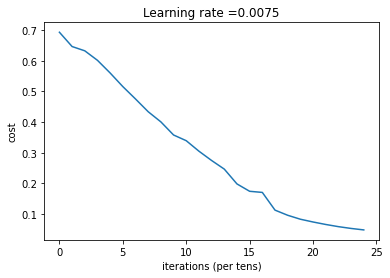

In [37]:
n_x = 12288
n_h = 7
n_y = 1
layers_dims = (n_x,n_h,n_y)

parameters = two_layer_model(train_x, train_set_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True,isPlot=True)

In [38]:
def predict(X, y, parameters):
    """
    该函数用于预测L层神经网络的结果，当然也包含两层
    
    参数：
     X - 测试集
     y - 标签
     parameters - 训练模型的参数
    
    返回：
     p - 给定数据集X的预测
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # 神经网络的层数
    p = np.zeros((1,m))
    
    #根据参数前向传播
    probas, caches = L_model_forward(X, parameters)
    
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    print("准确度为: "  + str(float(np.sum((p == y))/m)))
        
    return p


In [39]:
predictions_train = predict(train_x, train_y, parameters) #训练集
predictions_test = predict(test_x, test_y, parameters) #测试集

准确度为: 1.0
准确度为: 0.72


In [40]:
def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False,isPlot=True):
    """
    实现一个L层神经网络：[LINEAR-> RELU] *（L-1） - > LINEAR-> SIGMOID。
    
    参数：
        X - 输入的数据，维度为(n_x，例子数)
        Y - 标签，向量，0为非猫，1为猫，维度为(1,数量)
        layers_dims - 层数的向量，维度为(n_y,n_h,···,n_h,n_y)
        learning_rate - 学习率
        num_iterations - 迭代的次数
        print_cost - 是否打印成本值，每100次打印一次
        isPlot - 是否绘制出误差值的图谱
    
    返回：
     parameters - 模型学习的参数。 然后他们可以用来预测。
    """
    np.random.seed(1)
    costs = []
    
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0,num_iterations):
        AL , caches = L_model_forward(X,parameters)
        cost = compute_cost(AL,Y)
        grads = L_model_backward(AL,Y,caches)
        parameters = update_parameters(parameters,grads,learning_rate)
        
        #打印成本值，如果print_cost=False则忽略
        if i % 100 == 0:
            #记录成本
            costs.append(cost)
            #是否打印成本值
            if print_cost:
                print("第", i ,"次迭代，成本值为：" ,np.squeeze(cost))
    #迭代完成，根据条件绘制图
    if isPlot:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    return parameters

第 0 次迭代，成本值为： 0.715731513413713
第 100 次迭代，成本值为： 0.6747377593469114
第 200 次迭代，成本值为： 0.6603365433622127
第 300 次迭代，成本值为： 0.6462887802148751
第 400 次迭代，成本值为： 0.6298131216927773
第 500 次迭代，成本值为： 0.606005622926534
第 600 次迭代，成本值为： 0.5690041263975135
第 700 次迭代，成本值为： 0.519796535043806
第 800 次迭代，成本值为： 0.46415716786282285
第 900 次迭代，成本值为： 0.40842030048298916
第 1000 次迭代，成本值为： 0.37315499216069037
第 1100 次迭代，成本值为： 0.3057237457304712
第 1200 次迭代，成本值为： 0.2681015284774084
第 1300 次迭代，成本值为： 0.23872474827672593
第 1400 次迭代，成本值为： 0.20632263257914712
第 1500 次迭代，成本值为： 0.17943886927493544
第 1600 次迭代，成本值为： 0.15798735818801202
第 1700 次迭代，成本值为： 0.14240413012273906
第 1800 次迭代，成本值为： 0.12865165997885727
第 1900 次迭代，成本值为： 0.11244314998155124
第 2000 次迭代，成本值为： 0.08505631034966049
第 2100 次迭代，成本值为： 0.05758391198605336
第 2200 次迭代，成本值为： 0.04456753454693651
第 2300 次迭代，成本值为： 0.03808275166597559
第 2400 次迭代，成本值为： 0.034410749018402347


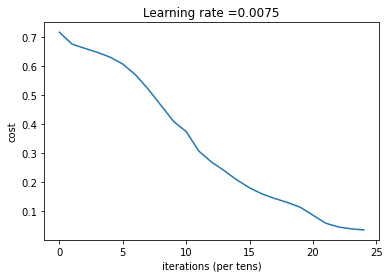

In [41]:
layers_dims = [12288, 20, 7, 5, 1] #  5-layer model
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True,isPlot=True)

In [42]:
pred_train = predict(train_x, train_y, parameters) #训练集
pred_test = predict(test_x, test_y, parameters) #测试集


准确度为: 0.9952153110047847
准确度为: 0.78
